<a href="https://colab.research.google.com/github/lauBit/proyecto-dos/blob/main/Evaluaci%C3%B3n_de_Calidad_de_Carros_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 – Modelos de clasificación supervisada para evaluar la calidad de un automovil

Integrantes del Grupo:
- Paola Romero
- Fernando Montaño
- Laura Camelo
- Daniel Garcia

## **Explicación breve del problema**.
Se desea realizar un modelo de nivel de evaluación de vehiculos basado en caracteristicas tales como: precio de compra, precio de mantenimiento, número de puertas, cupo de personas, tamaño del maletero, seguridad estimada del vehiculo.

## Importación de Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier

!pip install ucimlrepo

## Importación del Dataset "Car Evaluation"
El dataset se importa a través del paquete "ucimlrepo" y la librería "fetch_ucirepo" el cual se conecta directamente a la página web donde se encuentra alojado el dataset.

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

## Identificación de Variables y Registros
Se identifican 6 variables caracteristicas las cuales cuentan con un total de 1728 registros cada una. A continuación se relaciona el detalle de las variables mencionadas:
- `buying`: Precio de compra.
- `maint`: Precio del mantenimiento.
- `doors`: Número de puertas.
- `persons`: Cupo de personas.
- `lug_boot`: Tamaño del maletero.
- `safety`: Seguridad estimada del vehiculo.

Adicionalmente, se identifica que una variable objetivo llamada `class`, la cual cuenta con un total de 1728 registros al igual que lo identificado en las variables anteriores.



In [ ]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
dtypes: object(6)
memory usage: 81.1+ KB
None


In [ ]:
print(X.describe())

       buying  maint doors persons lug_boot safety
count    1728   1728  1728    1728     1728   1728
unique      4      4     4       3        3      3
top     vhigh  vhigh     2       2    small    low
freq      432    432   432     576      576    576


In [ ]:
#Se agrupan los valores
print(X.groupby('buying').size())
print(X.groupby('maint').size())
print(X.groupby('doors').size())
print(X.groupby('persons').size())
print(X.groupby('lug_boot').size())
print(X.groupby('safety').size())

buying
high     432
low      432
med      432
vhigh    432
dtype: int64
maint
high     432
low      432
med      432
vhigh    432
dtype: int64
doors
2        432
3        432
4        432
5more    432
dtype: int64
persons
2       576
4       576
more    576
dtype: int64
lug_boot
big      576
med      576
small    576
dtype: int64
safety
high    576
low     576
med     576
dtype: int64


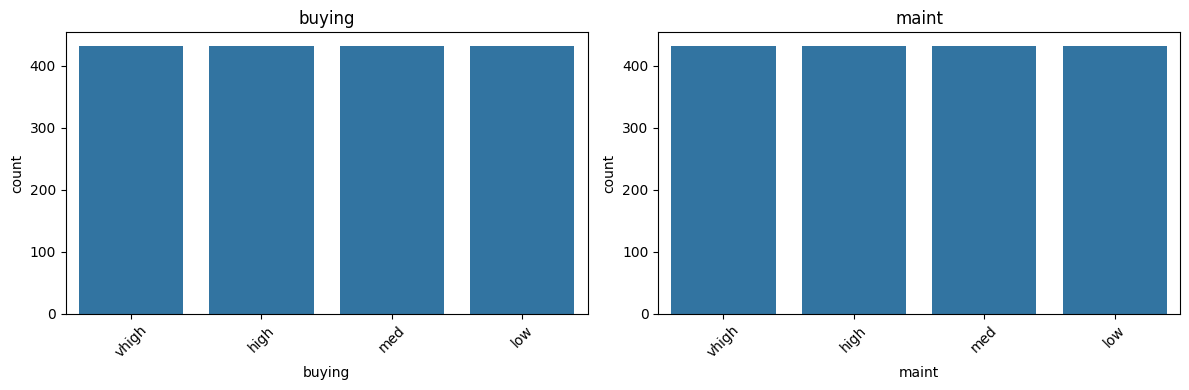

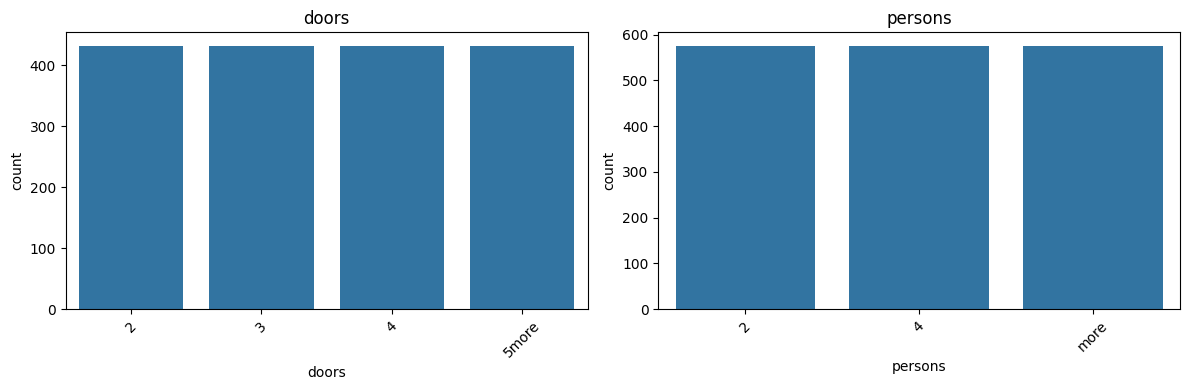

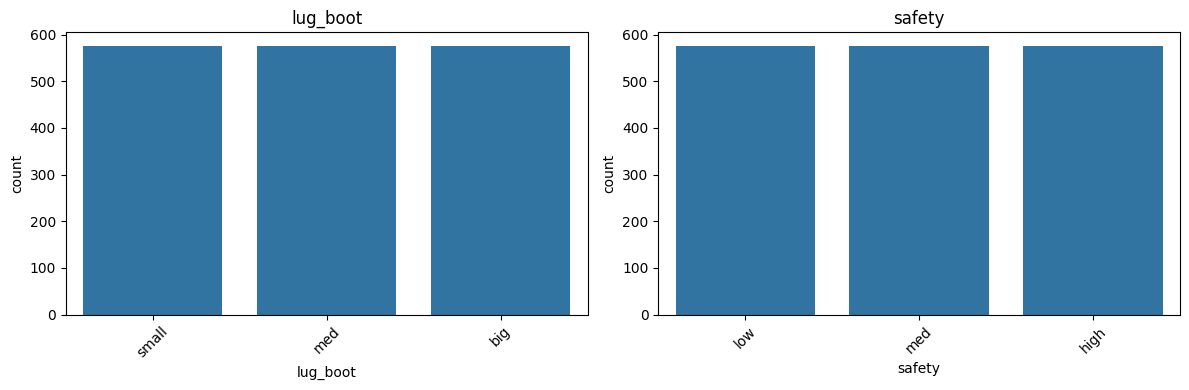

In [ ]:
#Gráfico de las variables
for i in range(0, len(X.columns), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for j, columna in enumerate(X.columns[i:i+2]):
        sns.countplot(x=columna, data=X, ax=axs[j])
        axs[j].set_title(columna)
        axs[j].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1728 non-null   object
dtypes: object(1)
memory usage: 13.6+ KB
None


In [ ]:
print(y.describe())

        class
count    1728
unique      4
top     unacc
freq     1210


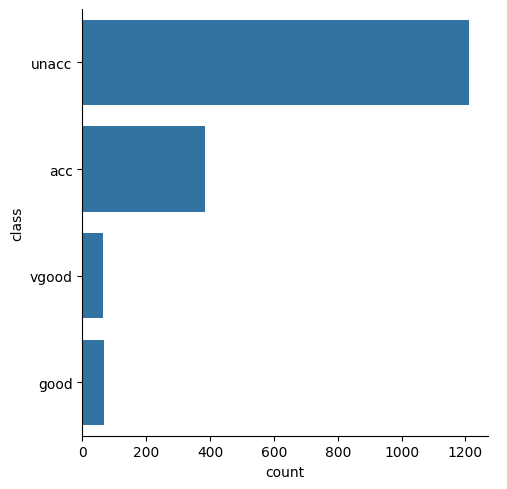

In [ ]:
sns.catplot(y='class', data=y, kind="count")

Una vez validada la información de las variables del dataset, no se identifican datos atipicos asi como valores nulos, por lo cual no se realizara ajustes sobre la data.

## Estandarización de las Variables a Numéricas

In [ ]:
X['buyingAjustado'] = X['buying'].map({'vhigh': 3, 'high':2, 'med':1, 'low':0}).astype(int)
X['maintAjustado'] = X['maint'].map({'vhigh': 3, 'high':2, 'med':1, 'low':0}).astype(int)
X['doorsAjustado'] = X['doors'].map({'5more': 3, '4':2, '3':1, '2':0}).astype(int)
X['personsAjustado'] = X['persons'].map({'more': 2, '4':1, '2':0}).astype(int)
X['lug_bootAjustado'] = X['lug_boot'].map({'big': 2, 'med':1, 'small':0}).astype(int)
X['safetyAjustado'] = X['safety'].map({'low': 0, 'med': 1, 'high': 2}).astype(int)

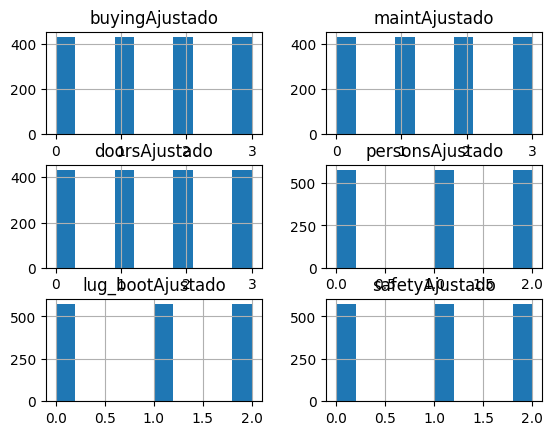

In [ ]:
X.hist()
plt.show()

De acuerdo con lo observado anteriormente, identificamos que los datos de las seis columnas "features" se encuentran balanceados.

## Implementación del Modelo "K-Nearest Neighbors"

### Partición de la data en conjuntos de entrenamiento y pruebas

In [ ]:
X_ajustado = X.drop(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ajustado, y, random_state=1)

### Entrenamiento del Modelo

In [ ]:
n_neighbors=7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=7)

Cabe resaltar que el valor de la variable `n_neighbors` fue seleccionado acorde con el número de variables "features" existentes en el dataset (6), ya que de acuerdo con las buenas prácticas para el uso de este modelo, se indica que al momento de contar con un total de variables caracteristicas par se recomienda utilizar un valor `k` impar.

### Predicción del Modelo

In [ ]:
knn.score(X_train, y_train)

0.9807098765432098

In [ ]:
knn.score(X_test, y_test)

0.9467592592592593

In [ ]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))

[[ 83   0   5   0]
 [  7  11   0   0]
 [  8   0 302   0]
 [  2   1   0  13]]


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         acc       0.83      0.94      0.88        88
        good       0.92      0.61      0.73        18
       unacc       0.98      0.97      0.98       310
       vgood       1.00      0.81      0.90        16

    accuracy                           0.95       432
   macro avg       0.93      0.84      0.87       432
weighted avg       0.95      0.95      0.95       432



Se obtiene una exactitud del modelo del 95%, lo que si bien indica un buen resultado para nuestro modelo, este valor es inferior al 98% obtenido en el modelo de `árbol de decisión`. De acuerdo con lo anterior, se reentrenará el modelo para obtener un valor `k` óptimo y se validará si la exactitud del modelo mejora.

### Re-entrenamiento del Modelo

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

([<matplotlib.axis.XTick at 0x79360c768250>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

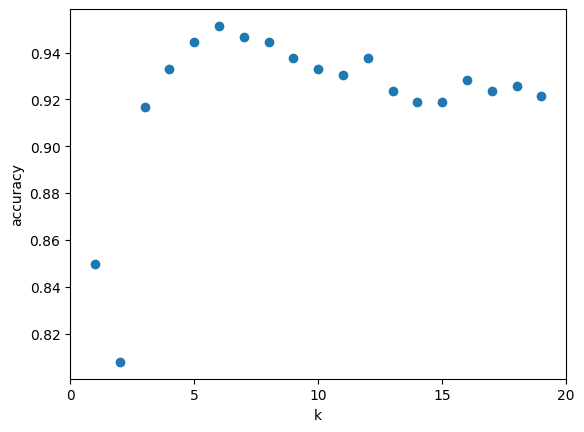

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

Se realiza la identificación del valor `k` óptimo para el modelo con el fin de realizar su respectivo re-entrenamiento y así obtener un mejor resultado de su exactitud. Sin embargo, de acuerdo con lo observado en la gráfica anterior, se obtiene que el valor `k` óptimo para el conjunto de datos de entrenamiento utilizado es 7, el cual corresponde al mismo valor utilizado en el entrenamiento inicial del modelo, por lo cual se finaliza con una exactitud del 95%.